# データ・サイエンス	データ・サイエンス社会応用論 / ICT社会応用演習Ⅳ
## 13-3. 基礎自治体の人口の確認

### 1. e-Stat のデータの読み込み
#### 1-a) 下準備

In [59]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import japanize_matplotlib

In [60]:
CENSUS_POPULATION_PATH = 'data/FEH_00200521_250109010954.csv'
LG_CODE_PATH = 'data/000925835.xlsx'
TOKYO_ADMIN_PATH = 'data/shape/N03-20240101_13.geojson'

#### 1-b) DataFrameへの読み込み

In [61]:
df_population = pd.read_csv(CENSUS_POPULATION_PATH, encoding='shift-jis', skiprows=14)
df_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6228 entries, 0 to 6227
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   時間軸（年次） コード                 6228 non-null   int64  
 1   時間軸（年次） 補助コード               0 non-null      float64
 2   時間軸（年次）                     6228 non-null   object 
 3   国籍総数か日本人 コード                6228 non-null   int64  
 4   国籍総数か日本人 補助コード              0 non-null      float64
 5   国籍総数か日本人                    6228 non-null   object 
 6   男女 コード                      6228 non-null   int64  
 7   男女 補助コード                    0 non-null      float64
 8   男女                          6228 non-null   object 
 9   全国，都道府県，市区町村（人口集中地区） コード    6228 non-null   int64  
 10  全国，都道府県，市区町村（人口集中地区） 補助コード  0 non-null      float64
 11  全国，都道府県，市区町村（人口集中地区）        6228 non-null   object 
 12  /年齢                         0 non-null      float64
 13  総数                          6228 

In [62]:
df_population

,時間軸（年次） コード,時間軸（年次） 補助コード,時間軸（年次）,国籍総数か日本人 コード,国籍総数か日本人 補助コード,国籍総数か日本人,男女 コード,男女 補助コード,男女,全国，都道府県，市区町村（人口集中地区） コード,...,90〜94歳,95〜99歳,100歳以上,年齢「不詳」,（再掲）15歳未満,（再掲）15〜64歳,（再掲）65歳以上,（再掲）75歳以上,（再掲）85歳以上,（再掲）20〜69歳
0,2020000000,NaN,2020年,0,NaN,国籍総数,0,NaN,総数,0,...,983383,253476,39738,2555614,10660791,52836316,22233206,11399430,3479063,53909973
1,2020000000,NaN,2020年,0,NaN,国籍総数,0,NaN,総数,1000,...,57245,15091,2263,52478,432950,2303957,1183622,587281,194610,2419768
2,2020000000,NaN,2020年,0,NaN,国籍総数,0,NaN,総数,1100,...,25388,6645,993,30514,209256,1156977,519290,252071,84863,1205248
3,2020000000,NaN,2020年,0,NaN,国籍総数,0,NaN,総数,1101,...,3176,800,113,9537,23694,156945,56397,27876,10309,161415
4,2020000000,NaN,2020年,0,NaN,国籍総数,0,NaN,総数,1102,...,3394,846,133,4328,32538,169440,73872,35192,11313,174756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6223,2020000000,NaN,2020年,1,NaN,うち日本人,2,NaN,女,47328,...,19,14,1,149,1006,2782,399,172,68,2666
6224,2020000000,NaN,2020年,1,NaN,うち日本人,2,NaN,女,47329,...,61,16,1,6,908,3201,1285,553,187,3334
6225,2020000000,NaN,2020年,1,NaN,うち日本人,2,NaN,女,47348,...,101,40,12,6,1592,5186,1751,857,330,5229
6226,2020000000,NaN,2020年,1,NaN,うち日本人,2,NaN,女,47350,...,137,40,8,15,3361,9927,2880,1317,462,9983


#### 1-c) DataFrameの下処理

In [64]:
df_population = df_population.rename(columns={
    '全国，都道府県，市区町村（人口集中地区） コード': 'code',
    '全国，都道府県，市区町村（人口集中地区）': 'name',
    '総数': 'total'
})
df_population['total'] = df_population['total'].apply(pd.to_numeric, errors='coerce')
df_population['under19'] = df_population['0〜4歳']+df_population['5〜9歳']+df_population['10〜14歳']+df_population['15〜19歳']
df_population['ratio19'] = df_population['under19'] / df_population['total']
df_population['95〜99歳'] = df_population['95〜99歳'].replace('-', 0).astype(int)
df_population['100歳以上'] = df_population['100歳以上'].replace('-', 0).astype(int)

df_population['over80'] = df_population['80〜84歳']+df_population['85〜89歳']+df_population['90〜94歳']+df_population['95〜99歳'].astype(int)+df_population['100歳以上'].astype(int)
df_population['ratio80'] = df_population['over80'] / df_population['total']

df_population = df_population[['code', 'name', 'total', 'under19', 'ratio19', 'over80', 'ratio80']]
df_population 

,code,name,total,under19,ratio19,over80,ratio80
0,0,全国,88285927,14633930,0.165756,6849469,0.077583
1,1000,北海道,3973007,605997,0.152529,366361,0.092213
2,1100,札幌市,1916037,291473,0.152123,156869,0.081872
3,1101,札幌市中央区,246573,33266,0.134913,18037,0.073151
4,1102,札幌市北区,280178,46236,0.165024,21546,0.076901
...,...,...,...,...,...,...,...
6223,47328,中城村,4336,1262,0.291052,112,0.025830
6224,47329,西原町,5400,1198,0.221852,363,0.067222
6225,47348,与那原町,8535,2047,0.239836,577,0.067604
6226,47350,南風原町,16183,4173,0.257863,850,0.052524


### 2. 地方公共団体コードの読み込み
#### 2-a) DataFrameへの読み込み

In [65]:
df_lg = pd.read_excel(LG_CODE_PATH, dtype=str)
df_lg

,団体コード,都道府県名\n（漢字）,市区町村名\n（漢字）,都道府県名\n（カナ）,市区町村名\n（カナ）
0,010006,北海道,NaN,ﾎｯｶｲﾄﾞｳ,NaN
1,011002,北海道,札幌市,ﾎｯｶｲﾄﾞｳ,ｻｯﾎﾟﾛｼ
2,012025,北海道,函館市,ﾎｯｶｲﾄﾞｳ,ﾊｺﾀﾞﾃｼ
3,012033,北海道,小樽市,ﾎｯｶｲﾄﾞｳ,ｵﾀﾙｼ
4,012041,北海道,旭川市,ﾎｯｶｲﾄﾞｳ,ｱｻﾋｶﾜｼ
...,...,...,...,...,...
1789,473618,沖縄県,久米島町,ｵｷﾅﾜｹﾝ,ｸﾒｼﾞﾏﾁｮｳ
1790,473626,沖縄県,八重瀬町,ｵｷﾅﾜｹﾝ,ﾔｴｾﾁｮｳ
1791,473758,沖縄県,多良間村,ｵｷﾅﾜｹﾝ,ﾀﾗﾏｿﾝ
1792,473812,沖縄県,竹富町,ｵｷﾅﾜｹﾝ,ﾀｹﾄﾐﾁｮｳ


In [66]:
df_lg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1794 entries, 0 to 1793
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   団体コード       1794 non-null   object
 1   都道府県名
（漢字）  1794 non-null   object
 2   市区町村名
（漢字）  1747 non-null   object
 3   都道府県名
（カナ）  1794 non-null   object
 4   市区町村名
（カナ）  1747 non-null   object
dtypes: object(5)
memory usage: 70.2+ KB


#### 2-b) DataFrameの下処理

In [67]:
df_lg = df_lg.rename(columns = {
    '団体コード': 'code',
    '都道府県名\n（漢字）': 'prefecture',
    '市区町村名\n（漢字）': 'city'
})
df_lg = df_lg[['code', 'prefecture', 'city']]
df_lg

,code,prefecture,city
0,010006,北海道,NaN
1,011002,北海道,札幌市
2,012025,北海道,函館市
3,012033,北海道,小樽市
4,012041,北海道,旭川市
...,...,...,...
1789,473618,沖縄県,久米島町
1790,473626,沖縄県,八重瀬町
1791,473758,沖縄県,多良間村
1792,473812,沖縄県,竹富町


In [68]:
df_lg['code'] = df_lg['code'].apply(lambda x: x[:5])
df_lg = df_lg[~df_lg['code'].str.endswith('000')]
df_lg

,code,prefecture,city
1,01100,北海道,札幌市
2,01202,北海道,函館市
3,01203,北海道,小樽市
4,01204,北海道,旭川市
5,01205,北海道,室蘭市
...,...,...,...
1789,47361,沖縄県,久米島町
1790,47362,沖縄県,八重瀬町
1791,47375,沖縄県,多良間村
1792,47381,沖縄県,竹富町


### 3. 国勢調査のデータと基礎自治体データの結合
#### 3-a) DataFrameの結合

In [69]:
df_population['code'] = df_population['code'].astype(int)
df_lg['code'] = df_lg['code'].astype(int)


/tmp/ipykernel_5356/1642814509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lg['code'] = df_lg['code'].astype(int)


In [70]:
df_lg_population = df_population.merge(df_lg, how='inner')
df_lg_population

,code,name,total,under19,ratio19,over80,ratio80,prefecture,city
0,1100,札幌市,1916037,291473,0.152123,156869,0.081872,北海道,札幌市
1,1202,函館市,216044,29577,0.136903,24011,0.111139,北海道,函館市
2,1203,小樽市,92939,11737,0.126287,12523,0.134744,北海道,小樽市
3,1204,旭川市,306545,45527,0.148517,32417,0.105750,北海道,旭川市
4,1205,室蘭市,68514,9962,0.145401,7807,0.113948,北海道,室蘭市
...,...,...,...,...,...,...,...,...,...
4885,47328,中城村,4336,1262,0.291052,112,0.025830,沖縄県,中城村
4886,47329,西原町,5400,1198,0.221852,363,0.067222,沖縄県,西原町
4887,47348,与那原町,8535,2047,0.239836,577,0.067604,沖縄県,与那原町
4888,47350,南風原町,16183,4173,0.257863,850,0.052524,沖縄県,南風原町


#### 3-b) データの確認

In [71]:
df_lg_population.sort_values('total', ascending=False)

,code,name,total,under19,ratio19,over80,ratio80,prefecture,city
308,14100,横浜市,3688620,596489,0.161711,277040,0.075107,神奈川県,横浜市
2753,14100,横浜市,3531352,583562,0.165252,275941,0.078140,神奈川県,横浜市
538,27100,大阪市,2752002,394991,0.143529,219418,0.079730,大阪府,大阪市
2983,27100,大阪市,2550571,382886,0.150118,214506,0.084101,大阪府,大阪市
449,23100,名古屋市,2303019,366113,0.158971,178549,0.077528,愛知県,名古屋市
...,...,...,...,...,...,...,...,...,...
1443,30361,湯浅町,2341,360,0.153780,213,0.090987,和歌山県,湯浅町
3888,30361,湯浅町,2319,360,0.155239,213,0.091850,和歌山県,湯浅町
4321,12226,富津市,2232,434,0.194444,198,0.088710,千葉県,富津市
3282,1226,砂川市,2231,247,0.110713,273,0.122367,北海道,砂川市


In [72]:
df_lg_population.sort_values('ratio19', ascending=False)

,code,name,total,under19,ratio19,over80,ratio80,prefecture,city
4074,47362,八重瀬町,4938,1661,0.336371,118,0.023896,沖縄県,八重瀬町
1629,47362,八重瀬町,4961,1662,0.335013,118,0.023786,沖縄県,八重瀬町
3753,23441,阿久比町,3392,1122,0.330778,133,0.039210,愛知県,阿久比町
1308,23441,阿久比町,3466,1133,0.326890,133,0.038373,愛知県,阿久比町
2938,23441,阿久比町,6760,2182,0.322781,327,0.048373,愛知県,阿久比町
...,...,...,...,...,...,...,...,...,...
2665,11348,鳩山町,6828,547,0.080111,822,0.120387,埼玉県,鳩山町
4503,22205,熱海市,6410,503,0.078471,1166,0.181903,静岡県,熱海市
1850,11348,鳩山町,3565,274,0.076858,442,0.123983,埼玉県,鳩山町
4295,11348,鳩山町,3534,270,0.076401,442,0.125071,埼玉県,鳩山町


In [92]:
df_lg_population.sort_values('ratio80', ascending=False)


,code,name,total,under19,ratio19,over80,ratio80,prefecture,city
4097,1226,砂川市,2798,281,0.100429,589,0.210508,北海道,砂川市
1652,1226,砂川市,2802,281,0.100286,589,0.210207,北海道,砂川市
4766,38204,八幡浜市,5865,700,0.119352,1222,0.208355,愛媛県,八幡浜市
4434,16209,小矢部市,2812,325,0.115576,579,0.205903,富山県,小矢部市
2321,38204,八幡浜市,5961,702,0.117765,1222,0.204999,愛媛県,八幡浜市
...,...,...,...,...,...,...,...,...,...
4070,47328,中城村,4284,1306,0.304855,78,0.018207,沖縄県,中城村
1625,47328,中城村,4632,1329,0.286917,79,0.017055,沖縄県,中城村
131,8220,つくば市,92467,20715,0.224026,1575,0.017033,茨城県,つくば市
3391,8220,つくば市,40482,10351,0.255694,663,0.016378,茨城県,つくば市


### 4. コロプレス図の作成
#### 4-a) 行政区域データの読み込み

In [73]:
gdf_tokyo_admin = gpd.read_file(TOKYO_ADMIN_PATH)
gdf_tokyo_admin

,N03_001,N03_002,N03_003,N03_004,N03_005,N03_007,geometry
0,東京都,None,None,所属未定地,None,13000,"POLYGON ((140.28925 30.48135, 140.28968 30.480..."
1,東京都,None,None,所属未定地,None,13000,"POLYGON ((139.82167 35.58322, 139.82187 35.583..."
2,東京都,None,None,所属未定地,None,13000,"POLYGON ((139.84130 35.64702, 139.84129 35.646..."
3,東京都,None,None,所属未定地,None,13000,"POLYGON ((140.05004 31.43993, 140.05002 31.439..."
4,東京都,None,None,所属未定地,None,13000,"POLYGON ((140.34167 29.79385, 140.34174 29.793..."
...,...,...,...,...,...,...,...
6899,東京都,None,None,小笠原村,None,13421,"POLYGON ((141.28634 24.79924, 141.28633 24.799..."
6900,東京都,None,None,小笠原村,None,13421,"POLYGON ((141.29279 24.74890, 141.29278 24.748..."
6901,東京都,None,None,小笠原村,None,13421,"POLYGON ((141.37959 24.78060, 141.37958 24.780..."
6902,東京都,None,None,小笠原村,None,13421,"POLYGON ((141.29002 24.74740, 141.29002 24.747..."


#### 4-b) 地方公共団体コードでグルーピング

In [74]:
gdf_tokyo_admin_grouped = gdf_tokyo_admin.dissolve(by='N03_007')
gdf_tokyo_admin_grouped = gdf_tokyo_admin_grouped.reset_index()
gdf_tokyo_admin_grouped

,N03_007,geometry,N03_001,N03_002,N03_003,N03_004,N03_005
0,13000,"MULTIPOLYGON (((140.34167 29.79385, 140.34161 ...",東京都,None,None,所属未定地,None
1,13101,"POLYGON ((139.77287 35.70370, 139.77287 35.703...",東京都,None,None,千代田区,None
2,13102,"POLYGON ((139.78341 35.69645, 139.78334 35.696...",東京都,None,None,中央区,None
3,13103,"MULTIPOLYGON (((139.77115 35.62838, 139.77115 ...",東京都,None,None,港区,None
4,13104,"POLYGON ((139.73333 35.70770, 139.73321 35.707...",東京都,None,None,新宿区,None
...,...,...,...,...,...,...,...
58,13381,"MULTIPOLYGON (((139.38455 34.04434, 139.38458 ...",東京都,None,None,三宅村,None
59,13382,"MULTIPOLYGON (((139.29851 33.65146, 139.29837 ...",東京都,None,None,御蔵島村,None
60,13401,"MULTIPOLYGON (((139.83879 33.04832, 139.83878 ...",東京都,None,None,八丈町,None
61,13402,"MULTIPOLYGON (((139.76717 32.44306, 139.76718 ...",東京都,None,None,青ヶ島村,None


#### 4-c) 国勢調査のDataFrameを結合

In [75]:
gdf_tokyo_admin_grouped['N03_007'] = gdf_tokyo_admin_grouped['N03_007'].astype(int)
df_population['code'] = df_population['code'].astype(int)


In [76]:
gdf_tokyo_population = gdf_tokyo_admin_grouped.merge(df_population, left_on='N03_007', right_on='code')
gdf_tokyo_population

,N03_007,geometry,N03_001,N03_002,N03_003,N03_004,N03_005,code,name,total,under19,ratio19,over80,ratio80
0,13000,"MULTIPOLYGON (((140.34167 29.79385, 140.34161 ...",東京都,None,None,所属未定地,None,13000,東京都,13844009,2080316,0.150268,989057,0.071443
1,13000,"MULTIPOLYGON (((140.34167 29.79385, 140.34161 ...",東京都,None,None,所属未定地,None,13000,東京都,6796702,1061858,0.156231,355188,0.052259
2,13000,"MULTIPOLYGON (((140.34167 29.79385, 140.34161 ...",東京都,None,None,所属未定地,None,13000,東京都,7047307,1018458,0.144517,633869,0.089945
3,13000,"MULTIPOLYGON (((140.34167 29.79385, 140.34161 ...",東京都,None,None,所属未定地,None,13000,東京都,13033396,2018415,0.154865,983436,0.075455
4,13000,"MULTIPOLYGON (((140.34167 29.79385, 140.34161 ...",東京都,None,None,所属未定地,None,13000,東京都,6392698,1030001,0.161121,353079,0.055232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,13303,"MULTIPOLYGON (((139.35725 35.74574, 139.35757 ...",東京都,None,西多摩郡,瑞穂町,None,13303,瑞穂町,11139,1806,0.162133,659,0.059162
302,13303,"MULTIPOLYGON (((139.35725 35.74574, 139.35757 ...",東京都,None,西多摩郡,瑞穂町,None,13303,瑞穂町,10922,1725,0.157938,1011,0.092565
303,13303,"MULTIPOLYGON (((139.35725 35.74574, 139.35757 ...",東京都,None,西多摩郡,瑞穂町,None,13303,瑞穂町,21503,3455,0.160675,1665,0.077431
304,13303,"MULTIPOLYGON (((139.35725 35.74574, 139.35757 ...",東京都,None,西多摩郡,瑞穂町,None,13303,瑞穂町,10854,1771,0.163166,658,0.060623


#### 4-d) 島嶼部の削除

In [77]:
min_lon, min_lat = 138.0, 35.0
max_lon, max_lat = 140.0, 36.0
   
bbox_polygon = Polygon([(min_lon, min_lat), (min_lon, max_lat), (max_lon, max_lat), (max_lon, min_lat)])

In [78]:
gdf_tokyo_population_clipped = gdf_tokyo_population[gdf_tokyo_population.within(bbox_polygon)]
gdf_tokyo_population_clipped

,N03_007,geometry,N03_001,N03_002,N03_003,N03_004,N03_005,code,name,total,under19,ratio19,over80,ratio80
6,13101,"POLYGON ((139.77287 35.70370, 139.77287 35.703...",東京都,None,None,千代田区,None,13101,千代田区,66680,11170,0.167516,3533,0.052984
7,13101,"POLYGON ((139.77287 35.70370, 139.77287 35.703...",東京都,None,None,千代田区,None,13101,千代田区,33637,5622,0.167137,1184,0.035199
8,13101,"POLYGON ((139.77287 35.70370, 139.77287 35.703...",東京都,None,None,千代田区,None,13101,千代田区,33043,5548,0.167902,2349,0.071089
9,13101,"POLYGON ((139.77287 35.70370, 139.77287 35.703...",東京都,None,None,千代田区,None,13101,千代田区,63790,10901,0.170889,3497,0.054821
10,13101,"POLYGON ((139.77287 35.70370, 139.77287 35.703...",東京都,None,None,千代田区,None,13101,千代田区,32065,5479,0.170872,1162,0.036239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,13303,"MULTIPOLYGON (((139.35725 35.74574, 139.35757 ...",東京都,None,西多摩郡,瑞穂町,None,13303,瑞穂町,11139,1806,0.162133,659,0.059162
302,13303,"MULTIPOLYGON (((139.35725 35.74574, 139.35757 ...",東京都,None,西多摩郡,瑞穂町,None,13303,瑞穂町,10922,1725,0.157938,1011,0.092565
303,13303,"MULTIPOLYGON (((139.35725 35.74574, 139.35757 ...",東京都,None,西多摩郡,瑞穂町,None,13303,瑞穂町,21503,3455,0.160675,1665,0.077431
304,13303,"MULTIPOLYGON (((139.35725 35.74574, 139.35757 ...",東京都,None,西多摩郡,瑞穂町,None,13303,瑞穂町,10854,1771,0.163166,658,0.060623


#### 4-e) コロプレス図の表示

<Axes: >

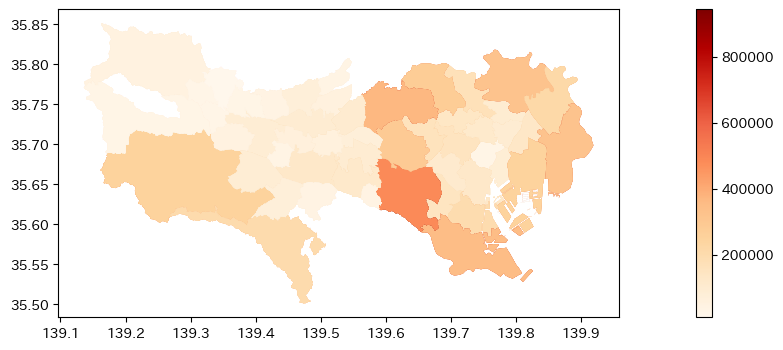

In [79]:
gdf_tokyo_population_clipped.plot(column='total', cmap='OrRd', legend=True, figsize=(20,4))

<Axes: >

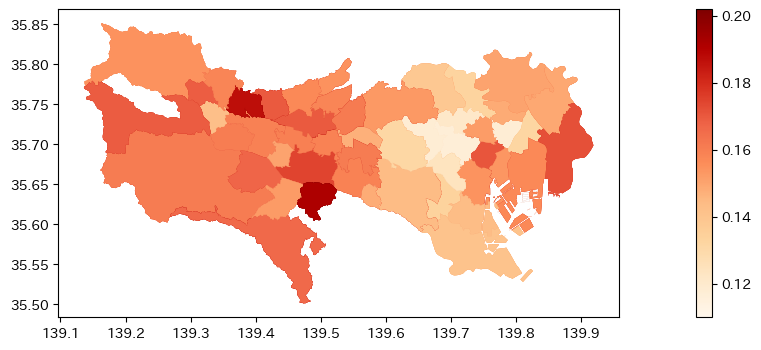

In [80]:
gdf_tokyo_population_clipped.plot(column='ratio19', cmap='OrRd', legend=True, figsize=(20,4))

In [81]:
df_lg_population.sort_values('ratio80', ascending=False)

,code,name,total,under19,ratio19,over80,ratio80,prefecture,city
4097,1226,砂川市,2798,281,0.100429,589,0.210508,北海道,砂川市
1652,1226,砂川市,2802,281,0.100286,589,0.210207,北海道,砂川市
4766,38204,八幡浜市,5865,700,0.119352,1222,0.208355,愛媛県,八幡浜市
4434,16209,小矢部市,2812,325,0.115576,579,0.205903,富山県,小矢部市
2321,38204,八幡浜市,5961,702,0.117765,1222,0.204999,愛媛県,八幡浜市
...,...,...,...,...,...,...,...,...,...
4070,47328,中城村,4284,1306,0.304855,78,0.018207,沖縄県,中城村
1625,47328,中城村,4632,1329,0.286917,79,0.017055,沖縄県,中城村
131,8220,つくば市,92467,20715,0.224026,1575,0.017033,茨城県,つくば市
3391,8220,つくば市,40482,10351,0.255694,663,0.016378,茨城県,つくば市


In [82]:
gdf_tokyo_admin = gpd.read_file(TOKYO_ADMIN_PATH)
gdf_tokyo_admin

,N03_001,N03_002,N03_003,N03_004,N03_005,N03_007,geometry
0,東京都,None,None,所属未定地,None,13000,"POLYGON ((140.28925 30.48135, 140.28968 30.480..."
1,東京都,None,None,所属未定地,None,13000,"POLYGON ((139.82167 35.58322, 139.82187 35.583..."
2,東京都,None,None,所属未定地,None,13000,"POLYGON ((139.84130 35.64702, 139.84129 35.646..."
3,東京都,None,None,所属未定地,None,13000,"POLYGON ((140.05004 31.43993, 140.05002 31.439..."
4,東京都,None,None,所属未定地,None,13000,"POLYGON ((140.34167 29.79385, 140.34174 29.793..."
...,...,...,...,...,...,...,...
6899,東京都,None,None,小笠原村,None,13421,"POLYGON ((141.28634 24.79924, 141.28633 24.799..."
6900,東京都,None,None,小笠原村,None,13421,"POLYGON ((141.29279 24.74890, 141.29278 24.748..."
6901,東京都,None,None,小笠原村,None,13421,"POLYGON ((141.37959 24.78060, 141.37958 24.780..."
6902,東京都,None,None,小笠原村,None,13421,"POLYGON ((141.29002 24.74740, 141.29002 24.747..."


In [83]:
gdf_tokyo_admin_grouped = gdf_tokyo_admin.dissolve(by='N03_007')
gdf_tokyo_admin_grouped = gdf_tokyo_admin_grouped.reset_index()
gdf_tokyo_admin_grouped

,N03_007,geometry,N03_001,N03_002,N03_003,N03_004,N03_005
0,13000,"MULTIPOLYGON (((140.34167 29.79385, 140.34161 ...",東京都,None,None,所属未定地,None
1,13101,"POLYGON ((139.77287 35.70370, 139.77287 35.703...",東京都,None,None,千代田区,None
2,13102,"POLYGON ((139.78341 35.69645, 139.78334 35.696...",東京都,None,None,中央区,None
3,13103,"MULTIPOLYGON (((139.77115 35.62838, 139.77115 ...",東京都,None,None,港区,None
4,13104,"POLYGON ((139.73333 35.70770, 139.73321 35.707...",東京都,None,None,新宿区,None
...,...,...,...,...,...,...,...
58,13381,"MULTIPOLYGON (((139.38455 34.04434, 139.38458 ...",東京都,None,None,三宅村,None
59,13382,"MULTIPOLYGON (((139.29851 33.65146, 139.29837 ...",東京都,None,None,御蔵島村,None
60,13401,"MULTIPOLYGON (((139.83879 33.04832, 139.83878 ...",東京都,None,None,八丈町,None
61,13402,"MULTIPOLYGON (((139.76717 32.44306, 139.76718 ...",東京都,None,None,青ヶ島村,None


In [84]:
gdf_tokyo_admin_grouped['N03_007'] = gdf_tokyo_admin_grouped['N03_007'].astype(int)
df_population['code'] = df_population['code'].astype(int)


In [85]:
gdf_tokyo_population = gdf_tokyo_admin_grouped.merge(df_population, left_on='N03_007', right_on='code')
gdf_tokyo_population

,N03_007,geometry,N03_001,N03_002,N03_003,N03_004,N03_005,code,name,total,under19,ratio19,over80,ratio80
0,13000,"MULTIPOLYGON (((140.34167 29.79385, 140.34161 ...",東京都,None,None,所属未定地,None,13000,東京都,13844009,2080316,0.150268,989057,0.071443
1,13000,"MULTIPOLYGON (((140.34167 29.79385, 140.34161 ...",東京都,None,None,所属未定地,None,13000,東京都,6796702,1061858,0.156231,355188,0.052259
2,13000,"MULTIPOLYGON (((140.34167 29.79385, 140.34161 ...",東京都,None,None,所属未定地,None,13000,東京都,7047307,1018458,0.144517,633869,0.089945
3,13000,"MULTIPOLYGON (((140.34167 29.79385, 140.34161 ...",東京都,None,None,所属未定地,None,13000,東京都,13033396,2018415,0.154865,983436,0.075455
4,13000,"MULTIPOLYGON (((140.34167 29.79385, 140.34161 ...",東京都,None,None,所属未定地,None,13000,東京都,6392698,1030001,0.161121,353079,0.055232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,13303,"MULTIPOLYGON (((139.35725 35.74574, 139.35757 ...",東京都,None,西多摩郡,瑞穂町,None,13303,瑞穂町,11139,1806,0.162133,659,0.059162
302,13303,"MULTIPOLYGON (((139.35725 35.74574, 139.35757 ...",東京都,None,西多摩郡,瑞穂町,None,13303,瑞穂町,10922,1725,0.157938,1011,0.092565
303,13303,"MULTIPOLYGON (((139.35725 35.74574, 139.35757 ...",東京都,None,西多摩郡,瑞穂町,None,13303,瑞穂町,21503,3455,0.160675,1665,0.077431
304,13303,"MULTIPOLYGON (((139.35725 35.74574, 139.35757 ...",東京都,None,西多摩郡,瑞穂町,None,13303,瑞穂町,10854,1771,0.163166,658,0.060623


In [86]:
min_lon, min_lat = 138.0, 35.0
max_lon, max_lat = 140.0, 36.0
   
bbox_polygon = Polygon([(min_lon, min_lat), (min_lon, max_lat), (max_lon, max_lat), (max_lon, min_lat)])

In [87]:
gdf_tokyo_population_clipped = gdf_tokyo_population[gdf_tokyo_population.within(bbox_polygon)]
gdf_tokyo_population_clipped

,N03_007,geometry,N03_001,N03_002,N03_003,N03_004,N03_005,code,name,total,under19,ratio19,over80,ratio80
6,13101,"POLYGON ((139.77287 35.70370, 139.77287 35.703...",東京都,None,None,千代田区,None,13101,千代田区,66680,11170,0.167516,3533,0.052984
7,13101,"POLYGON ((139.77287 35.70370, 139.77287 35.703...",東京都,None,None,千代田区,None,13101,千代田区,33637,5622,0.167137,1184,0.035199
8,13101,"POLYGON ((139.77287 35.70370, 139.77287 35.703...",東京都,None,None,千代田区,None,13101,千代田区,33043,5548,0.167902,2349,0.071089
9,13101,"POLYGON ((139.77287 35.70370, 139.77287 35.703...",東京都,None,None,千代田区,None,13101,千代田区,63790,10901,0.170889,3497,0.054821
10,13101,"POLYGON ((139.77287 35.70370, 139.77287 35.703...",東京都,None,None,千代田区,None,13101,千代田区,32065,5479,0.170872,1162,0.036239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,13303,"MULTIPOLYGON (((139.35725 35.74574, 139.35757 ...",東京都,None,西多摩郡,瑞穂町,None,13303,瑞穂町,11139,1806,0.162133,659,0.059162
302,13303,"MULTIPOLYGON (((139.35725 35.74574, 139.35757 ...",東京都,None,西多摩郡,瑞穂町,None,13303,瑞穂町,10922,1725,0.157938,1011,0.092565
303,13303,"MULTIPOLYGON (((139.35725 35.74574, 139.35757 ...",東京都,None,西多摩郡,瑞穂町,None,13303,瑞穂町,21503,3455,0.160675,1665,0.077431
304,13303,"MULTIPOLYGON (((139.35725 35.74574, 139.35757 ...",東京都,None,西多摩郡,瑞穂町,None,13303,瑞穂町,10854,1771,0.163166,658,0.060623


<Axes: >

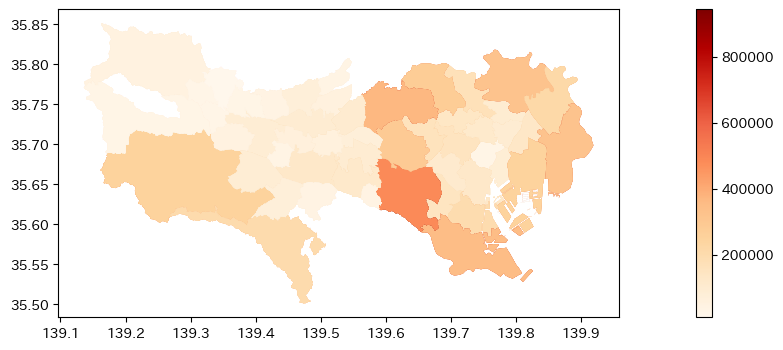

In [88]:
gdf_tokyo_population_clipped.plot(column='total', cmap='OrRd', legend=True, figsize=(20,4))

<Axes: >

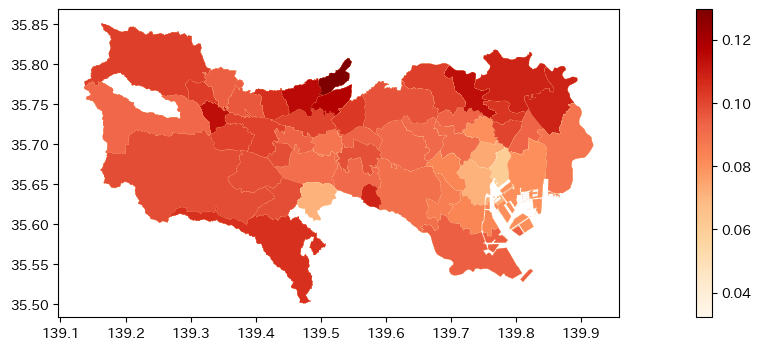

In [90]:
gdf_tokyo_population_clipped.plot(column='ratio80', cmap='OrRd', legend=True, figsize=(20,4))